## Load dataset

In [21]:
from sklearn.datasets import fetch_openml
import numpy as np

In [22]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [23]:
partial_size = 50

In [24]:
X_partial = X[::partial_size]
X_partial.shape

(1400, 784)

In [25]:
y_partial = np.array([int(y) for y in y[::partial_size]])
y_partial.shape

(1400,)

Chaque observation de ce jeu de données est une image de 28 pixels par 28 pixels, dont l’étiquette y[i] est le chiffre qu’elle représente, et les 784 features le niveau de gris (entre 0 et 255) du pixel correspondant (car 28 x 28 = 784)

## Display demo image

In [26]:
import matplotlib.pyplot as plt

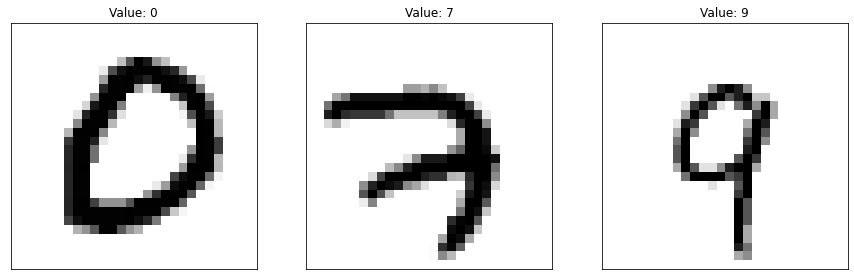

In [27]:
fig = plt.figure(figsize=(15,10))

for i,sample_idx in enumerate([42, 100, 238]):
    ax = fig.add_subplot(1,3,i+1)
    sample_image = np.reshape(X_partial[sample_idx, :], (28, 28))
    plt.imshow(sample_image, cmap='binary')
    plt.xticks([]), plt.yticks([])
    plt.title(f"Value: {y_partial[sample_idx]}")

## Feature Scaling

In [28]:
from sklearn import preprocessing

In [29]:
std_scale = preprocessing.StandardScaler().fit(X_partial)
X_scaled = std_scale.transform(X_partial)

## 1/ Clustering

effectuer un partitionnement de X en 10 clusters, avec l’algorithme de clustering de votre choix

In [10]:
from sklearn import cluster

In [48]:
dbscan = cluster.DBSCAN(eps=15, min_samples=5)
dbscan.fit(X_scaled)
clusters = dbscan.labels_

In [49]:
clusters

array([-1,  0, -1, ..., -1,  1,  1])

## 2/ Visualize

visualiser le résultat de ce clustering en deux dimensions

#### Dimentionality Reduction (t-SNE)

In [51]:
from sklearn import manifold
#tsne = manifold.TSNE(n_components=2, init='pca') #, random_state=0)
tsne = manifold.TSNE(n_components=2, random_state=42, verbose=0, perplexity=40, n_iter=300)

In [52]:
X_projected_tnse = tsne.fit_transform(X_scaled)

#### Plotting

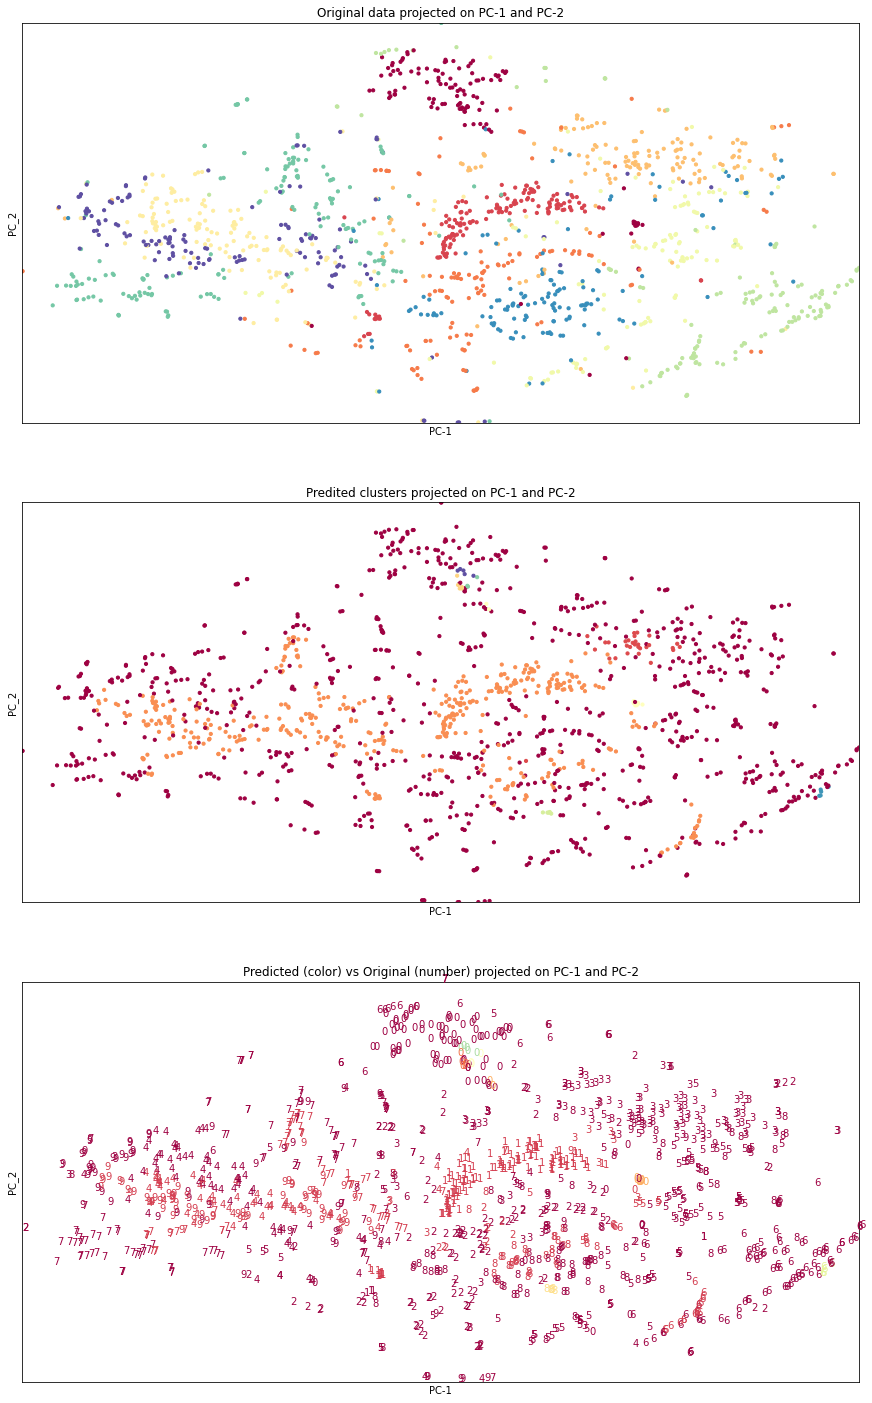

In [53]:
fig = plt.figure(figsize=(15,25))

ax = fig.add_subplot(311)
ax.scatter(X_projected_tnse[:, 0], X_projected_tnse[:, 1], s=10, c=y_partial , cmap=plt.cm.Spectral)
plt.xticks([]), plt.yticks([])
plt.title("Original data projected on PC-1 and PC-2")
ax.set_xlabel("PC-1")
ax.set_ylabel("PC_2")
plt.xlim([np.min(X_projected_tnse[:, 0]), np.max(X_projected_tnse[:, 0])])
plt.ylim([np.min(X_projected_tnse[:, 1]), np.max(X_projected_tnse[:, 1])])


ax = fig.add_subplot(312)
ax.scatter(X_projected_tnse[:, 0], X_projected_tnse[:, 1], s=10, c=clusters , cmap=plt.cm.Spectral)
plt.xticks([]), plt.yticks([])
plt.title("Predited clusters projected on PC-1 and PC-2")
ax.set_xlabel("PC-1")
ax.set_ylabel("PC_2")
plt.xlim([np.min(X_projected_tnse[:, 0]), np.max(X_projected_tnse[:, 0])])
plt.ylim([np.min(X_projected_tnse[:, 1]), np.max(X_projected_tnse[:, 1])])


ax = fig.add_subplot(313)
for i,c in enumerate(clusters):
    ax.text(X_projected_tnse[i,0], X_projected_tnse[i,1], y_partial[i], color=plt.cm.Spectral(clusters[i]/10.))

plt.xticks([]), plt.yticks([])
plt.title("Predicted (color) vs Original (number) projected on PC-1 and PC-2")
ax.set_xlabel("PC-1")
ax.set_ylabel("PC_2")
plt.xlim([np.min(X_projected_tnse[:, 0]), np.max(X_projected_tnse[:, 0])])
plt.ylim([np.min(X_projected_tnse[:, 1]), np.max(X_projected_tnse[:, 1])])

plt.show()

## 3/ Evaluate

évaluer la qualité de ce partitionnement:
- d’une part intrinsèquement (sans utiliser y)
- et d’autre part en le comparant aux chiffres représentés par les images (en utilisant y).

In [61]:
from sklearn import metrics 

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_} / {len(y_partial)}")
print(f"Homogeneity: {metrics.homogeneity_score(y_partial, clusters):0.3f}")
print(f"Completeness: {metrics.completeness_score(y_partial, clusters):0.3f}")
print(f"V-measure: {metrics.v_measure_score(y_partial, clusters):0.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y_partial, clusters):0.3f}")
print(f"Adjusted Mutual Information: {metrics.adjusted_mutual_info_score(y_partial, clusters):0.3f}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(X_partial, clusters):0.3f}")
print(f"David Bouldin Score: {metrics.davies_bouldin_score(X, clusters):0.3f}")

Estimated number of clusters: 8
Estimated number of noise points: 915 / 1400
Homogeneity: 0.131
Completeness: 0.352
V-measure: 0.190
Adjusted Rand Index: 0.055
Adjusted Mutual Information: 0.176
Silhouette Coefficient: -0.065


**Silhouette Coefficient**: The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. (**Pour l’évaluation intrinsèque**)

**Adjusted Rand Index**: The adjusted Rand index is ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation). (**Pour la comparaison aux étiquettes**)

**David Bouldin Score**: The minimum score is zero, with lower values indicating better clustering.